# New Measure - Vitamin B complex per 1000 patients

## Rationale

There has been a [measure on Vitamin B complex tablets](https://openprescribing.net/measure/vitb/) for several years on OpenPrescribing.  The existing indicator measures the proportion of Vitamin B complex compared with prescriptions for thiamine.  This was based on [2010 NICE guidance](https://www.nice.org.uk/guidance/cg100/chapter/Recommendations#wernickes-encephalopathy), stating that Vitamin B compound tabs do not have enough thiamine to prevent Wernicke's Encephalopathy in alcohol disorders, the most common indication for prescription.

Recently, [Regional Medicines Optimisation Guidance has been released](https://www.sps.nhs.uk/wp-content/uploads/2019/12/RMOC-position-statement-oral-vitamin-B-supplementation-in-alcoholism-v1.0-1.pdf), which more forcfully suggests that Vitamin B compound should not be prescribed.  It states:

Due to a lack of evidence on their efficacy and safety, vitamin B complex preparations (vitamin B compound
and vitamin B compound strong tablets) should not be prescribed for prevention of Wernicke’s
Encephalopathy (WE) in alcoholism.

* Vitamin B complex preparations should not be prescribed for preventing deficiency or for maintenance treatment following treatment for deficiency.

* Vitamin B complex preparations should not be prescribed as dietary supplements. Patients who wish to use them for dietary supplementation should be advised to purchase them over the counter.

* Vitamin B compound strong tablets may be prescribed on a short-term basis (10 days) for patients at risk of refeeding syndrome. This also applies to patients who are not harmful or dependent drinkers.

* In rare cases where there might be a justifiable reason for prescribing vitamin B complex e.g. medically diagnosed deficiency or chronic malabsorption, vitamin B compound strong and not vitamin B compound should be prescribed as it represents better value for money.

It also suggests:

* Do not initiate vitamin B compound or vitamin B compound strong tablets for any of the following indications:
    * Prevention of WE in alcoholism
    * Dietary supplementation
    * Prevention of deficiency
    * Maintenance treatment following treatment of deficiency
* Review all existing patients prescribed vitamin B complex preparations with a view to stopping treatment in all but exceptional circumstances, such as in those patients with a medically diagnosed deficiency due to lifelong or chronic condition, or following surgery that results in malabsorption. If all relevant patient factors have been taken into account and it is considered appropriate to stop, treatment may be stopped immediately.
* The decision to discontinue treatment should be carefully explained to the patient, and should emphasise the positive aspects of discontinued prescribing of drugs with a low clinical value.
* Advise patients who wish to use these vitamin B preparations as dietary supplements to purchase them over the counter.

It is therefore suggested, taking into account the above guidance, that we produce a new measure showing the total items of Vitamin B compound preparations per 1000 patients.

## Proposed Measure

**Vitamin B complex prescribing per 1000 patients**: 

**Prescribing of vitamin B complex (normal and strong tablets) per 1000 registered patients**: 

**Why It Matters**: 

One of the most common reasons why vitamin B has been prescribed is to prevent Wernicke's encephalopathy in chronic alcohol disorders. A recent position statment from the Regional Medicines Optimisation Committee (RMOC) [states that](https://www.sps.nhs.uk/wp-content/uploads/2019/12/RMOC-position-statement-oral-vitamin-B-supplementation-in-alcoholism-v1.0-1.pdf):

* Due to a lack of evidence on their efficacy and safety, vitamin B complex preparations (vitamin B compound and vitamin B compound strong tablets) should not be prescribed for prevention of Wernicke’s Encephalopathy (WE) in alcoholism
* Vitamin B complex preparations should not be prescribed for preventing deficiency or for maintenance treatment following treatment for deficiency.
* Vitamin B complex preparations should not be prescribed as dietary supplements. Patients who wish to use them for dietary ",
    "supplementation should be advised to purchase them over the counter.  Vitamin B compound strong tablets may be prescribed on a short-term basis (10 days) for patients at risk of refeeding syndrome. This also applies to patients who are not harmful or dependent drinkers. In rare cases where there might be a justifiable reason for prescribing vitamin B complex e.g. medically diagnosed deficiency or chronic malabsorption, vitamin B compound strong and not vitamin B compound should be prescribed as it represents better value for money.

The RMOC advice is to review all existing patients prescribed vitamin B complex preparations with a view to stopping treatment in all but exceptional circumstances, such as in those patients with a medically diagnosed deficiency due to lifelong or chronic condition, or following surgery that results in malabsorption.



### Numerators and Denominators

Numerator: `bnf_code LIKE '0906027G0%' --Vit B Compound`

Denominator: patient list size



## SQL and results

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [16]:
#calculate the number of items per 1000 patients for Vit B Co and Vit B Co Forte tablets
sql = """
SELECT rx.month, rx.pct, sum(rx.items) as items, total_list_size, 
1000*sum(ieee_divide(rx.items,total_list_size)) as measure --calculates number of items and items per 1000 patients
FROM
hscic.normalised_prescribing_standard as rx
INNER JOIN (
SELECT
  prac.ccg_id as ccg,
  month,
  SUM(total_list_size) AS total_list_size
FROM
  hscic.practice_statistics AS prac_stats
INNER JOIN
  hscic.practices AS prac
ON
prac.code=prac_stats.practice
INNER JOIN
  hscic.ccgs as ccgs
ON
prac.ccg_id = ccgs.code
WHERE
ccgs.org_type = 'CCG'
GROUP BY
  month,
  prac.ccg_id) AS stats --this creates the list size for a CCG, and ensures that only CCGs are included in the data
ON
  rx.month=stats.month
  AND rx.pct=stats.ccg
WHERE 
bnf_code like '0906027G0%' --Vit B Compound
GROUP BY rx.month, rx.pct, stats.total_list_size
ORDER BY month
"""
vitb_df = bq.cached_read(sql, csv_path='vitb_df.csv', use_cache=True)
vitb_df['month'] = vitb_df['month'].astype('datetime64[ns]')


## Changes in prescribing levels

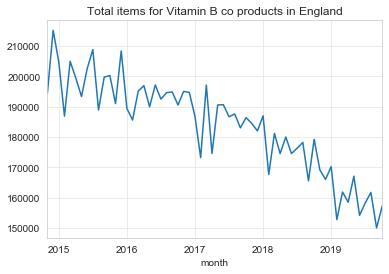

In [17]:
#plot data on graph
vitb_df.groupby(["month"])['items'].sum().plot(kind='line', title="Total items for Vitamin B co products in England")

This shows that, although reducing, there has been significant prescribing of Vit B Co in the last five years.

## Modelling for measure

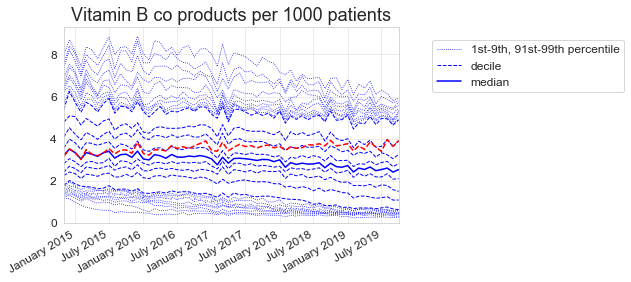

In [19]:
#create sample deciles
charts.deciles_chart(
        vitb_df,
        period_column='month',
        column='measure',
        title="Vitamin B co products per 1000 patients",
        show_outer_percentiles=True)

#add in example CCG (Devon - 15N)
df_subject = vitb_df.loc[vitb_df['pct'] == '15N']
plt.plot(df_subject['month'], df_subject['measure'], 'r--')
plt.show()

There is significant use in some CCGs, along with significant variation.

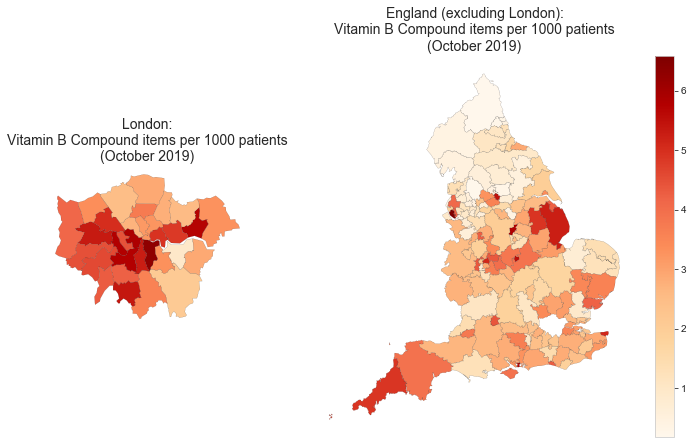

In [20]:
#create choropeth map of 1kcal/ml per 1000 patients
plt.figure(figsize=(12, 7))
latest_per_1000_df = vitb_df.loc[vitb_df['month'] == '2019-10-01']
plt = maps.ccg_map(latest_per_1000_df, title="Vitamin B Compound items per 1000 patients\n(October 2019)", column='measure', cartogram=False, separate_london=True)
plt.show()

## Proposed JSON

```{
  "name": "Vitamin B complex",
  "title": [
    "Vitamin B complex prescribing per 1000 patients"
  ],
  "description": [
    "Prescribing of vitamin B complex (normal and strong tablets) per 1000 registered patients"
  ],
  "why_it_matters": [
    "One of the most common reasons why vitamin B has been prescribed is to prevent Wernicke's encephalopathy in chronic alcohol disorders. ",
    "A recent position statment from the Regional Medicines Optimisation Committee (RMOC) ",
    "<a href='https://www.sps.nhs.uk/wp-content/uploads/2019/12/RMOC-position-statement-oral-vitamin-B-supplementation-in-alcoholism-v1.0-1.pdf'>",
    "states that:</a></p>",
    "<ul>",
    "<li>Due to a lack of evidence on their efficacy and safety, vitamin B complex preparations (vitamin B compound and ",
    "vitamin B compound strong tablets) should not be prescribed for prevention of Wernicke’s Encephalopathy (WE) in alcoholism</li>",
    "<li>Vitamin B complex preparations should not be prescribed for preventing deficiency or for maintenance treatment following",
    "treatment for deficiency.</li>",
    "<li>Vitamin B complex preparations should not be prescribed as dietary supplements. Patients who wish to use them for dietary ",
    "supplementation should be advised to purchase them over the counter.</li>",
    "<li>Vitamin B compound strong tablets may be prescribed on a short-term basis (10 days) for patients at risk of refeeding ",
    "syndrome. This also applies to patients who are not harmful or dependent drinkers.</li>",
    "<li>In rare cases where there might be a justifiable reason for prescribing vitamin B complex e.g. medically diagnosed ",
    "deficiency or chronic malabsorption, vitamin B compound strong and not vitamin B compound should be prescribed as it ",
    "represents better value for money.<li>",
    "</ul>",
    "<p>The RMOC advice is to review all existing patients prescribed vitamin B complex preparations with a view to stopping treatment ",
    "in all but exceptional circumstances, such as in those patients with a medically diagnosed deficiency due to lifelong or ",
    "chronic condition, or following surgery that results in malabsorption."
    
  ],
  "numerator_short": "Vitamin B complex items",
  "denominator_short": "1000 patients",
  "url": null,
  "is_percentage": false,
  "is_cost_based": false,
  "low_is_good": true,
  "tags": [
    "core",
    "efficacy",
    "nice"
  ],
  "numerator_type": "bnf_items",
  "numerator_where": [
    "bnf_code LIKE '0906027G0%' --Vit B Compound"
  ],
  "denominator_type": "list_size",
  "date_reviewed": [
    ""
  ],
  "next_review": [
    ""
  ],
  "authored_by": [
    "richard.croker@phc.ox.ac.uk"
  ],
  "checked_by": [
    ""
  ],
  "measure_complexity": [
    "low"
  ],
  "measure_notebook_url": [
    ""
  ]
}```